In [1]:
#!/usr/bin/env python
# coding: utf-8

import os, sys
import logging

import numpy as np
import h5netcdf

import xarray as xr
import xarray.ufuncs as xu
import xrft
import pandas as pd
from scipy.signal import convolve2d, detrend

from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy

plt.rc("figure", figsize=(12,10))
plt.rc("font", size=14)

from dask.distributed import Client, LocalCluster
#
# Initialisation d'un cluster de 32 coeurs
cluster = LocalCluster(processes=False, n_workers=1, threads_per_worker=4, silence_logs='error')
client = Client(cluster)
client

/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43973 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://137.129.155.67:43973/status,
Dashboard: http://137.129.155.67:43973/status,Workers: 1
Total threads: 4,Total memory: 78.61 GiB
Status: running,Using processes: False
Comm: inproc://137.129.155.67/9047/1,Workers: 1
Dashboard: http://137.129.155.67:43973/status,Total threads: 4
Started: Just now,Total memory: 78.61 GiB
Comm: inproc://137.129.155.67/9047/4,Total threads: 4
Dashboard: http://137.129.155.67:48403/status,Memory: 78.61 GiB
Nanny: None,


In [2]:
path = "/home/durand/Documents/OLR/"

indir_data = path + 'Anomaly/'
outdir_TF = path + 'TF2D/'

indir_data_RAW = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/RAW_ANOMALY/OLR/'
indir_data_FILTERED = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/FILTERED_ANOMALY/OLR/'

var_file = 'anom_OLR_brut_ERA5_3H'


In [3]:
year = 2009
latitude = -10.5
longitude = 105.5

ds_RAW = xr.open_mfdataset(indir_data_RAW+'*'+var_file+'*'+str(year)+'.nc', chunks = {'time' : 1}, parallel=True)
ds_RAW.assign_coords(lon=(((ds_RAW.lon + 180) % 360) - 180))
# ds_RAW = ds_RAW.isel(time = slice(0,None,8))
ds_FILTER = xr.open_mfdataset(indir_data_FILTERED + '*' + str(year) + '_V2.nc', chunks = {'time' : 1}, parallel=True)
ds_FILTER_2 = xr.open_mfdataset(indir_data_FILTERED + 'ER_SECOND_3.nc', chunks = {'time' : 1}, parallel=True)

# ds_FILTER = ds_FILTER.isel(time = slice(0,None,8))
ds_ERWAN = xr.open_mfdataset('/cnrm/tropics/user/peyrille/Stage_PFE_Erwan/data/OLR/'+'*'+str(year)+'.nc', chunks = {'time' : 1}, parallel=True)
# ds_ERWAN

In [4]:
da_OLR_Kelvin = ds_FILTER['OLR_Kelvin']
da_OLR_Rossby = ds_FILTER['OLR_Rossby']
da_OLR_MJO = ds_FILTER['OLR_MJO']
da_OLR_MRG = ds_FILTER['OLR_MRG']
da_OLR_EIG = ds_FILTER['OLR_EIG']
da_OLR_WIG = ds_FILTER['OLR_WIG']
da_OLR_TD = ds_FILTER['OLR_TD']
da_OLR_LF = ds_FILTER['OLR_LF'] 

In [5]:
da_FILTER_TOT = da_OLR_Kelvin + \
                da_OLR_Rossby + \
                da_OLR_MJO + \
                da_OLR_MRG + \
                da_OLR_EIG + \
                da_OLR_WIG + \
                da_OLR_TD + \
                da_OLR_LF

In [6]:
da_OLR_Rossby.sel(lat = latitude, lon = longitude, method = 'nearest')

<xarray.DataArray 'OLR_Rossby' (time: 365)>
dask.array<getitem, shape=(365,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2009-01-01 2009-01-02 ... 2009-12-31
    lat      float32 -10.0
    lon      float32 105.0
Attributes:
    units:    W/m^2
    tMin:     9.7
    tMax:     48.0
    kMin:     -10
    kMax:     -1
    hMin:     8
    hMax:     90

In [7]:
ds_ERWAN

<xarray.Dataset>
Dimensions:   (time: 365, lat: 33, lon: 144)
Coordinates:
  * lat       (lat) float32 -40.0 -37.5 -35.0 -32.5 ... 32.5 35.0 37.5 40.0
  * lon       (lon) float32 -177.5 -175.0 -172.5 -170.0 ... 175.0 177.5 180.0
  * time      (time) datetime64[ns] 2009-01-01 2009-01-02 ... 2009-12-31
Data variables: (12/13)
    aew2_10   (time, lat, lon) float32 dask.array<chunksize=(1, 33, 144), meta=np.ndarray>
    er_ki     (time, lat, lon) float32 dask.array<chunksize=(1, 33, 144), meta=np.ndarray>
    er_wk     (time, lat, lon) float32 dask.array<chunksize=(1, 33, 144), meta=np.ndarray>
    klv_sk    (time, lat, lon) float32 dask.array<chunksize=(1, 33, 144), meta=np.ndarray>
    klv_wk    (time, lat, lon) float32 dask.array<chunksize=(1, 33, 144), meta=np.ndarray>
    low       (time, lat, lon) float32 dask.array<chunksize=(1, 33, 144), meta=np.ndarray>
    ...        ...
    mjo_wk    (time, lat, lon) float32 dask.array<chunksize=(1, 33, 144), meta=np.ndarray>
    mrg       (time, lat, lon) float32 dask.array<chunksize=(1, 33, 144), meta=np.ndarray>
    mrg_td    (time, lat, lon) float32 dask.array<chunksize=(1, 33, 144), meta=np.ndarray>
    olr       (time, lat, lon) float32 dask.array<chunksize=(1, 33, 144), meta=np.ndarray>
    olr_anom  (time, lat, lon) float32 dask.array<chunksize=(1, 33, 144), meta=np.ndarray>
    td        (time, lat, lon) float32 dask.array<chunksize=(1, 33, 144), meta=np.ndarray>
Attributes:
    history:  Fri Jun 18 10:15:57 2021: ncks -O --mk_rec_dmn time olr_anom_wk...
    NCO:      netCDF Operators version 4.9.2 (Homepage = http://nco.sf.net, C...

In [8]:
ds_ERWAN['low']

<xarray.DataArray 'low' (time: 365, lat: 33, lon: 144)>
dask.array<open_dataset-b37f50e60262dc189cb4b310bb3a6d43low, shape=(365, 33, 144), dtype=float32, chunksize=(1, 33, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -40.0 -37.5 -35.0 -32.5 -30.0 ... 32.5 35.0 37.5 40.0
  * lon      (lon) float32 -177.5 -175.0 -172.5 -170.0 ... 175.0 177.5 180.0
  * time     (time) datetime64[ns] 2009-01-01 2009-01-02 ... 2009-12-31
Attributes: (12/17)
    valid_range:           [-32765  17235]
    parent_stat:           Individual Obs
    statistic:             Mean
    level_desc:            Other
    dataset:               NOAA Interpolated OLR
    precision:             2
    ...                    ...
    lat:                   40.0
    wavenumber:            [-10  10]
    period:                [120. 999.]
    depth:                 [999 999]
    waveName:              Low
    name:                  low frequency

In [9]:
ds_FILTER_2

<xarray.Dataset>
Dimensions:  (lat: 13, lon: 144, time: 365)
Coordinates:
  * lat      (lat) float32 -15.0 -12.5 -10.0 -7.5 -5.0 ... 7.5 10.0 12.5 15.0
  * lon      (lon) float32 -177.5 -175.0 -172.5 -170.0 ... 175.0 177.5 180.0
  * time     (time) datetime64[ns] 2009-01-01 2009-01-02 ... 2009-12-31
Data variables:
    er_wk    (time, lat, lon) float32 dask.array<chunksize=(1, 13, 144), meta=np.ndarray>

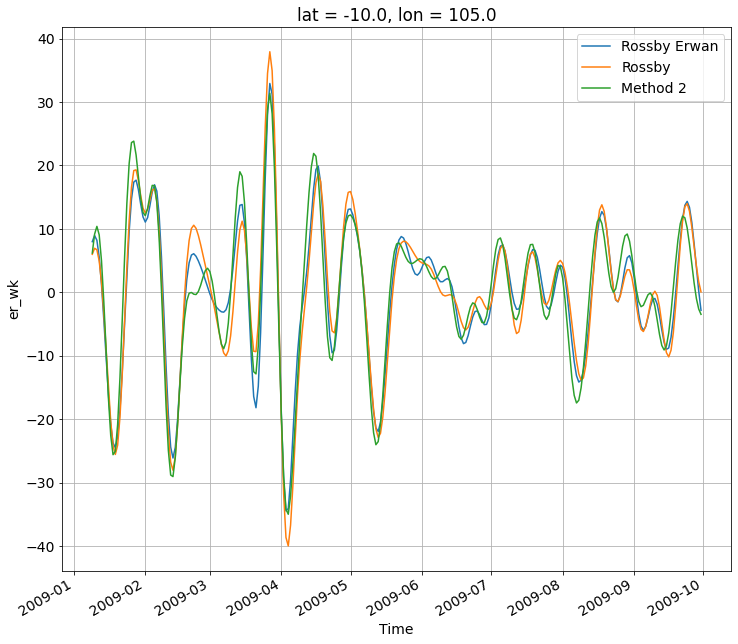

In [15]:
ds_ERWAN['er_wk'].sel(lat = latitude, lon = longitude, method = 'nearest').sel(time = slice('01-09-2009', '30-09-2009')).plot(label = 'Rossby Erwan')
da_OLR_Rossby.sel(lat = latitude, lon = longitude, method = 'nearest').sel(time = slice('01-09-2009', '30-09-2009')).plot(label = 'Rossby')
ds_FILTER_2['er_wk'].sel(lat = latitude, lon = longitude, method = 'nearest').sel(time = slice('01-09-2009', '30-09-2009')).plot(label = 'Method 2')
plt.legend()
plt.grid()

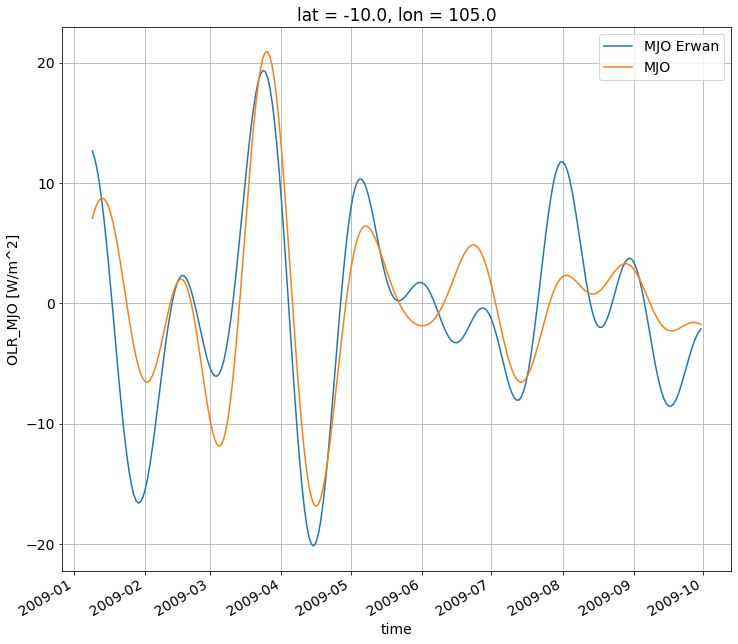

In [18]:
ds_ERWAN['mjo_wk'].sel(lat = latitude, lon = longitude, method = 'nearest').sel(time = slice('01-09-2009', '30-09-2009')).plot(label = 'MJO Erwan')
da_OLR_MJO.sel(lat = latitude, lon = longitude, method = 'nearest').sel(time = slice('01-09-2009', '30-09-2009')).plot(label = 'MJO')
plt.legend()
plt.grid()

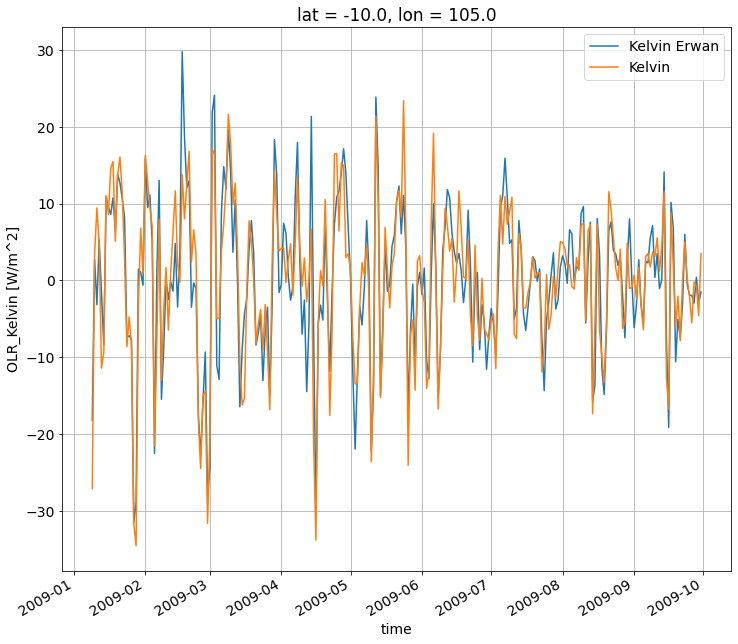

In [19]:
ds_ERWAN['klv_wk'].sel(lat = latitude, lon = longitude, method = 'nearest').sel(time = slice('01-09-2009', '30-09-2009')).plot(label = 'Kelvin Erwan')
da_OLR_Kelvin.sel(lat = latitude, lon = longitude, method = 'nearest').sel(time = slice('01-09-2009', '30-09-2009')).plot(label = 'Kelvin')
plt.legend()
plt.grid()

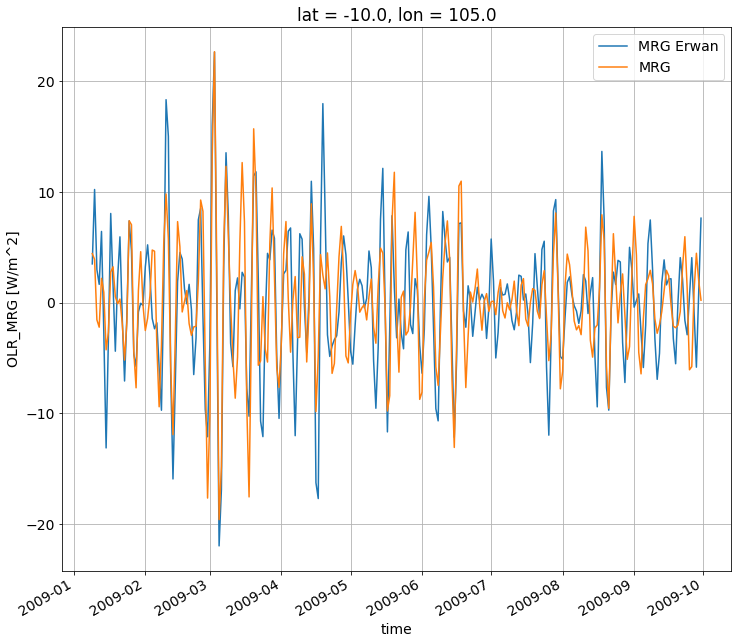

In [20]:
ds_ERWAN['mrg'].sel(lat = latitude, lon = longitude, method = 'nearest').sel(time = slice('01-09-2009', '30-09-2009')).plot(label = 'MRG Erwan')
da_OLR_MRG.sel(lat = latitude, lon = longitude, method = 'nearest').sel(time = slice('01-09-2009', '30-09-2009')).plot(label = 'MRG')
plt.legend()
plt.grid()

In [14]:
ds_ERWAN['mrg']

<xarray.DataArray 'mrg' (time: 365, lat: 33, lon: 144)>
dask.array<open_dataset-b37f50e60262dc189cb4b310bb3a6d43mrg, shape=(365, 33, 144), dtype=float32, chunksize=(1, 33, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -40.0 -37.5 -35.0 -32.5 -30.0 ... 32.5 35.0 37.5 40.0
  * lon      (lon) float32 -177.5 -175.0 -172.5 -170.0 ... 175.0 177.5 180.0
  * time     (time) datetime64[ns] 2009-01-01 2009-01-02 ... 2009-12-31
Attributes: (12/17)
    name:                  low frequency 
    valid_range:           [-32765  17235]
    parent_stat:           Individual Obs
    statistic:             Mean
    level_desc:            Other
    dataset:               NOAA Interpolated OLR
    ...                    ...
    long_name:              olr anomaly
    lat:                   40.0
    wavenumber:            [-20  -1]
    period:                [ 3. 10.]
    depth:                 [ 8 90]
    waveName:              MRG